NOTE: defining the HOME path constant

In [1]:
import os
HOME = os.getcwd()
print(f'HOME directory path: \'{HOME}\'')

HOME directory path: '/content'


### Important ! Add "requirements.txt" file to working directory

#### Installing required packages

In [3]:
!pip install -r {HOME}/requirements.txt --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 84.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.7/898.7 kB 51.4 MB/s eta 0:00:00


### Connecting to Roboflow dataset

In [4]:
import roboflow
roboflow.login(force=True) # Login into roboflow

visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········


In [5]:
rf = roboflow.Roboflow()

In [24]:
project = rf.workspace("stormdamagechallenge").project("hurricanedamagev7-f6aoq")
version_dataset = 3
dataset = project.version(version_dataset).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Exporting format yolov8 in progress : 85.0%
Version export complete for yolov8 format



Extracting Dataset Version Zip to hurricanedamagev7-3 in yolov8:: 100%|██████████| 11846/11846 [00:06<00:00, 1876.99it/s]


### Import remaining packages

In [8]:
import torch

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# GeoTiff Images
import rasterio
from osgeo import gdal

# Visualisation
from matplotlib import pyplot as plt
import matplotlib.image as img
from matplotlib.pyplot import figure
from PIL import Image

# Model Building
import ultralytics
from ultralytics import YOLO
from IPython.display import Image

# Progress bar
from tqdm import tqdm

import numpy as np

# Others
import os
import shutil
import zipfile

%matplotlib inline

Check the version of Ultralytics

In [9]:
ultralytics.checks()

Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 33.3/112.6 GB disk)


In [10]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
1


In [11]:
!nvidia-smi

Tue Dec 10 19:17:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Loading Yolov8 model

In [12]:
# Loading the model
model = YOLO('../models/yolov8/yolov8n.pt')
# Display model information (optional)
model.info()

100%|██████████| 6.25M/6.25M [00:00<00:00, 154MB/s]


YOLOv8n summary: 225 layers, 3,157,200 parameters, 0 gradients, 8.9 GFLOPs


(225, 3157200, 0, 8.8575488)

### Training Model

In [25]:
yaml_file = f'{HOME}/hurricanedamagev7-{version_dataset}/data.yaml'
yaml_file

'/content/hurricanedamagev7-3/data.yaml'

#### Resume model training from last step (optional)

In [ ]:
# Resuming model training from last completed epoch
# model = YOLO('runs/detect/train/weights/last.pt')

In [26]:
# Train the model on the dataset for 20 epochs
batch = -1 #
device = 0 # 0: GPU | 'cpu': cpu | 'mps': apple silicon mps
epochs = 20
patience = 5
imgsz = 512
plots = True
name = 'testing_data_splits_ratios'
project = 'exploratory_phase'

model.train(data=yaml_file, batch = batch, device = device, epochs = epochs, patience = patience, imgsz = imgsz, plots = plots, name = name, project = project)

Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=../models/yolov8/yolov8n.pt, data=/content/hurricanedamagev7-3/data.yaml, epochs=20, time=None, patience=5, batch=-1, imgsz=512, save=True, save_period=-1, cache=False, device=0, workers=8, project=exploratory_phase, name=testing_data_splits_ratios2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, sa

train: Scanning /content/hurricanedamagev7-3/train/labels... 4736 images, 1 backgrounds, 0 corrupt: 100%|██████████| 4736/4736 [00:02<00:00, 1636.72it/s]


train: New cache created: /content/hurricanedamagev7-3/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
AutoBatch: Computing optimal batch size for imgsz=512 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla T4) 14.75G total, 0.26G reserved, 0.14G allocated, 14.35G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     3011628       5.246         0.241         45.29         18.32        (1, 3, 512, 512)                    list
     3011628       10.49         0.266         23.23         15.84        (2, 3, 512, 512)                    list
     3011628       20.99         0.369         26.17         16.76        (4, 3, 512, 512)                    list
     3011628       41.97         0.682         24.83         23.47        (8

train: Scanning /content/hurricanedamagev7-3/train/labels.cache... 4736 images, 1 backgrounds, 0 corrupt: 100%|██████████| 4736/4736 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/hurricanedamagev7-3/valid/labels... 597 images, 1 backgrounds, 0 corrupt: 100%|██████████| 597/597 [00:00<00:00, 646.59it/s]

val: New cache created: /content/hurricanedamagev7-3/valid/labels.cache


Plotting labels to exploratory_phase/testing_data_splits_ratios2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0008515625), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to exploratory_phase/testing_data_splits_ratios2
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      15.6G     0.8679      0.959     0.9999       1179        512: 100%|██████████| 44/44 [01:03<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.21s/it]

                   all        597      10864      0.562      0.605      0.608      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      13.6G      0.868     0.9373      1.002       1378        512: 100%|██████████| 44/44 [01:03<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.23s/it]

                   all        597      10864      0.551      0.607      0.588      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      12.9G     0.8898     0.9646      1.015       1254        512: 100%|██████████| 44/44 [01:00<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.42s/it]

                   all        597      10864      0.478      0.547      0.508      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      13.1G     0.9013     0.9855      1.019       1146        512: 100%|██████████| 44/44 [01:06<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.11s/it]

                   all        597      10864      0.517        0.6      0.541      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      14.8G     0.8863     0.9547      1.014       1177        512: 100%|██████████| 44/44 [01:04<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.16s/it]

                   all        597      10864      0.496      0.563      0.541      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      11.4G     0.8773     0.9449       1.01       1200        512: 100%|██████████| 44/44 [01:03<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.48s/it]


                   all        597      10864      0.571      0.597      0.605      0.449
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

6 epochs completed in 0.121 hours.
Optimizer stripped from exploratory_phase/testing_data_splits_ratios2/weights/last.pt, 6.2MB
Optimizer stripped from exploratory_phase/testing_data_splits_ratios2/weights/best.pt, 6.2MB

Validating exploratory_phase/testing_data_splits_ratios2/weights/best.pt...
Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.20s/it]


                   all        597      10864      0.562      0.604      0.608      0.456
damagedcommercialbuilding        243        469      0.361      0.416       0.36      0.237
damagedresidentialbuilding        435       1788      0.495      0.657      0.595      0.435
undamagedcommercialbuilding        343       1260      0.628      0.451      0.565      0.428
undamagedresidentialbuilding        456       7347      0.765      0.892      0.913      0.722
Speed: 0.2ms preprocess, 1.6ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to exploratory_phase/testing_data_splits_ratios2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a412196f7f0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [19]:
name = 'testing_data_splits_ratios'
project = 'exploratory_phase'
# /content/exploratory_phase/testing_data_splits_ratios/confusion_matrix_normalized.png
f'{HOME}/{project}/{name}/confusion_matrix_normalized.png'

'/content/exploratory_phase/testing_data_splits_ratios/confusion_matrix_normalized.png'

/content


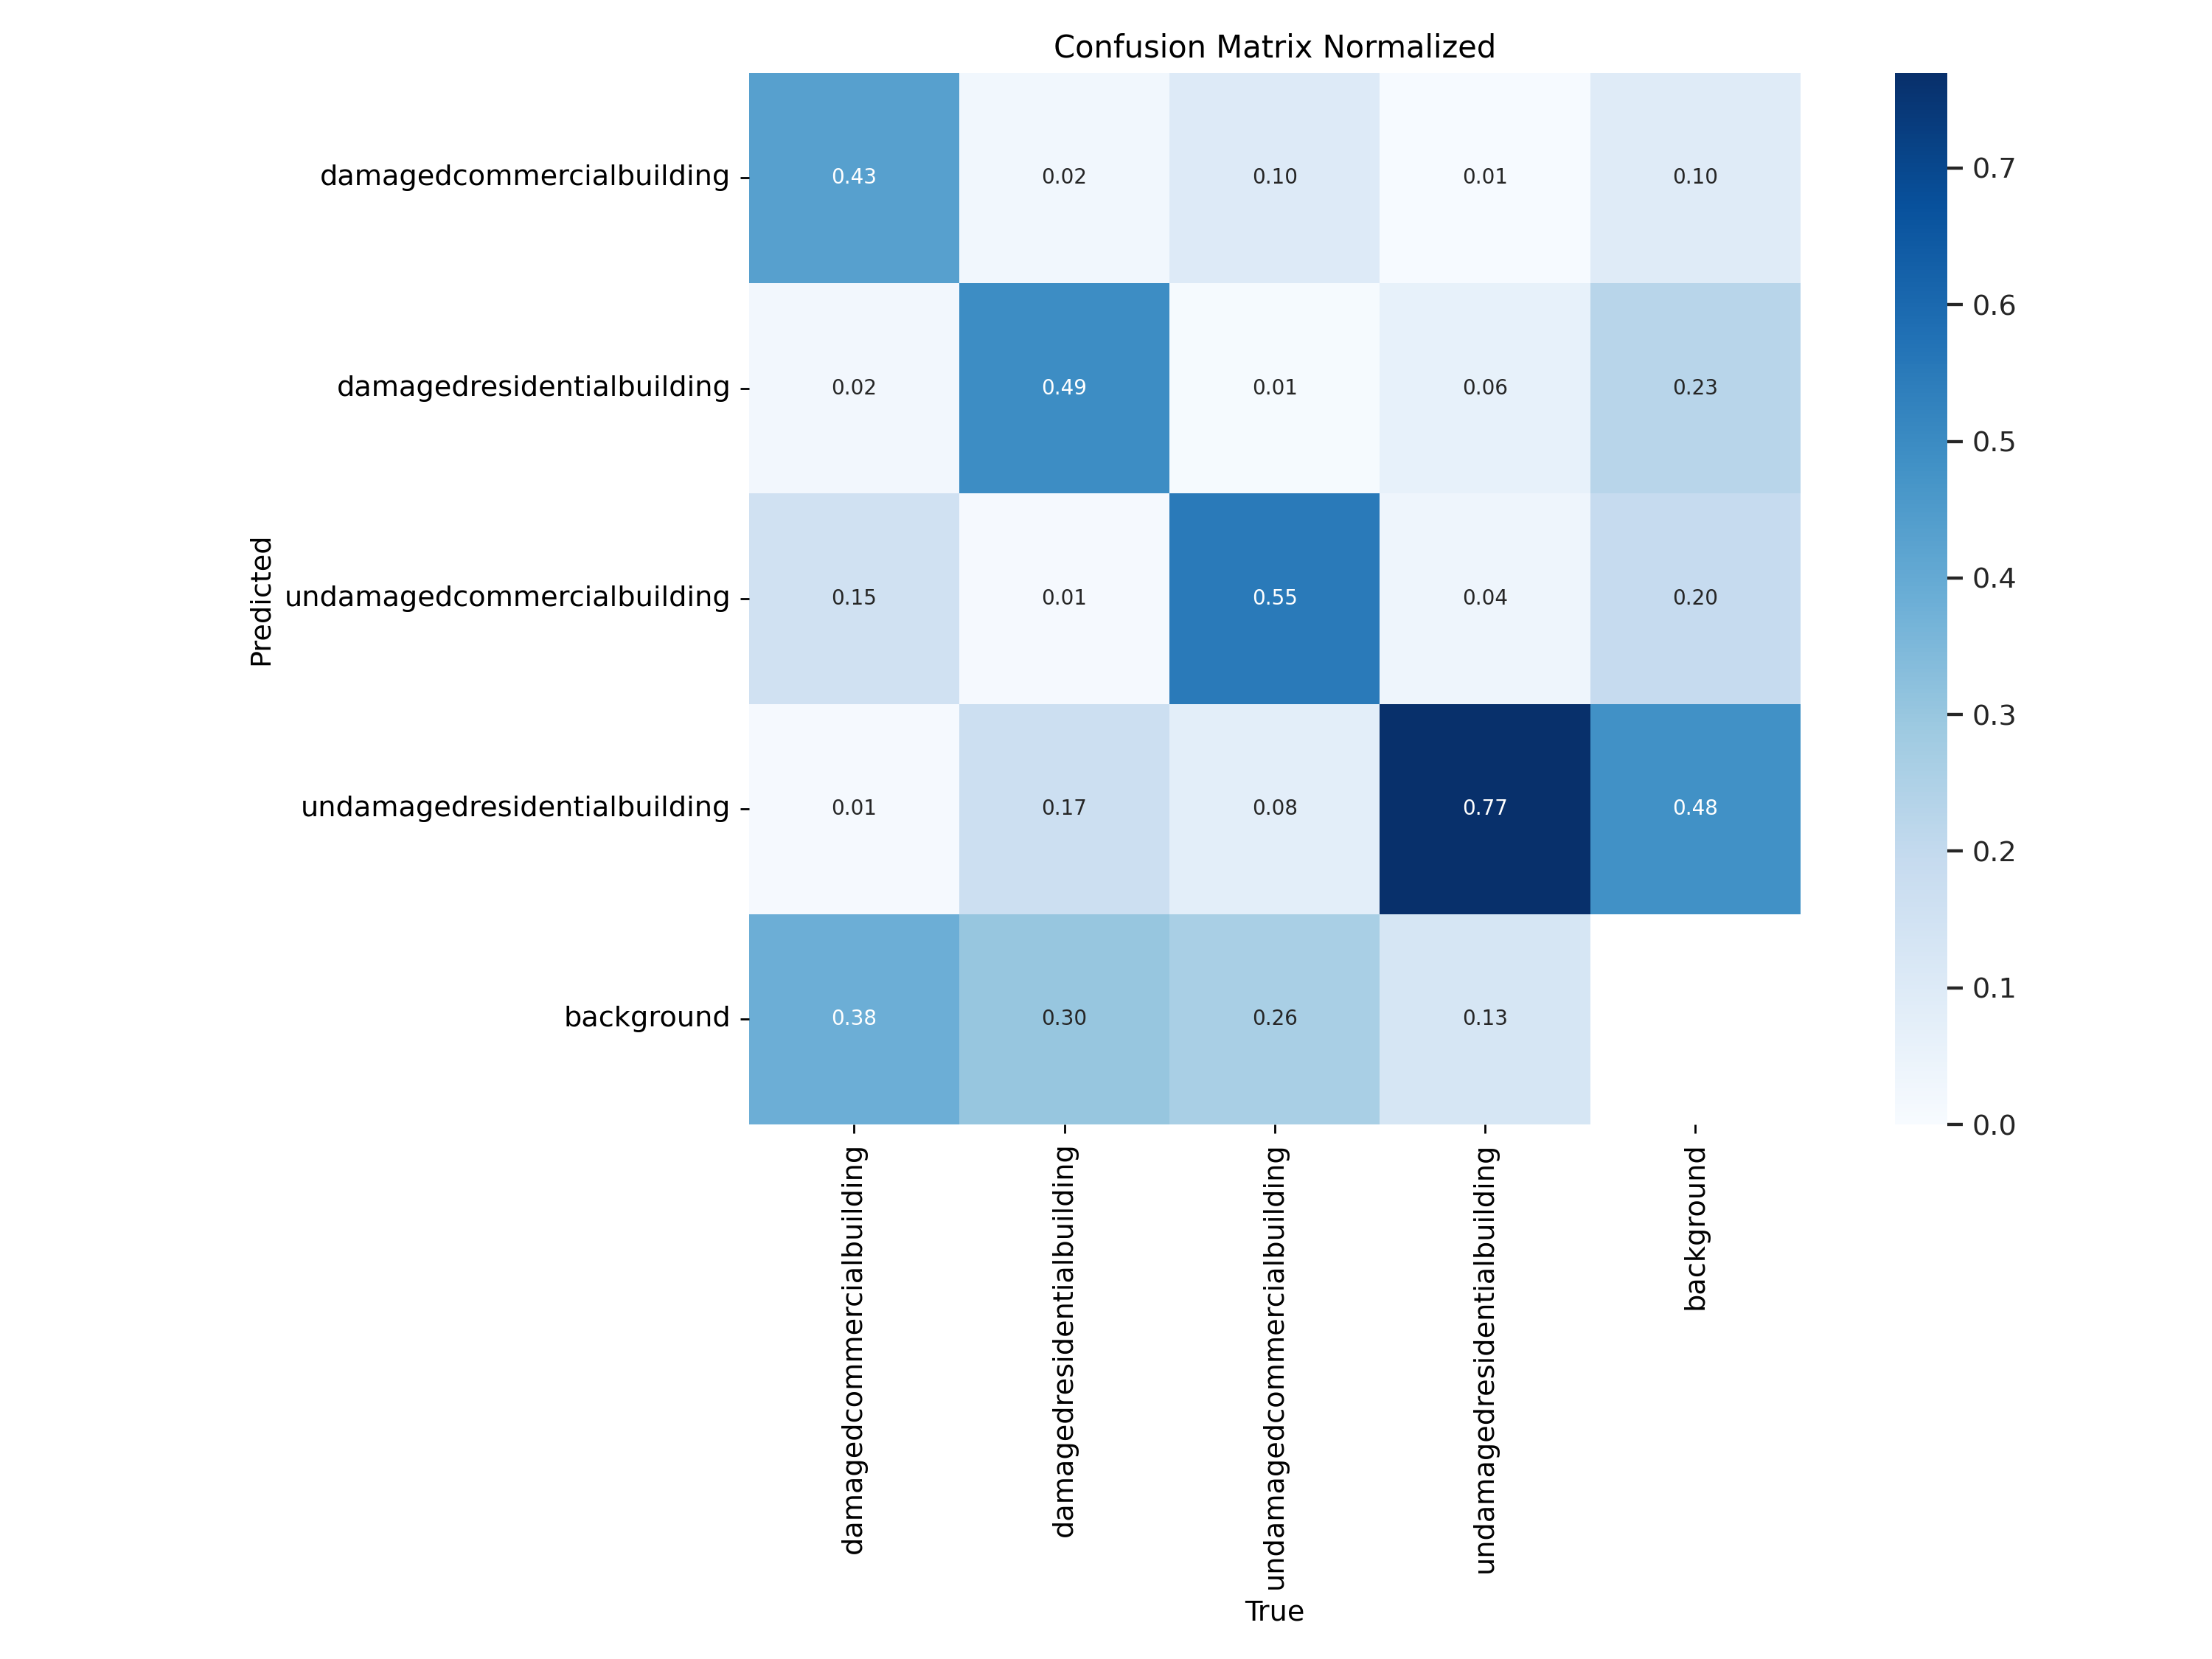

In [27]:
%cd {HOME}
Image(filename=f'{HOME}/{project}/{name}/confusion_matrix_normalized.png', width=600) # FIRST RUN: 20 epochs

/content


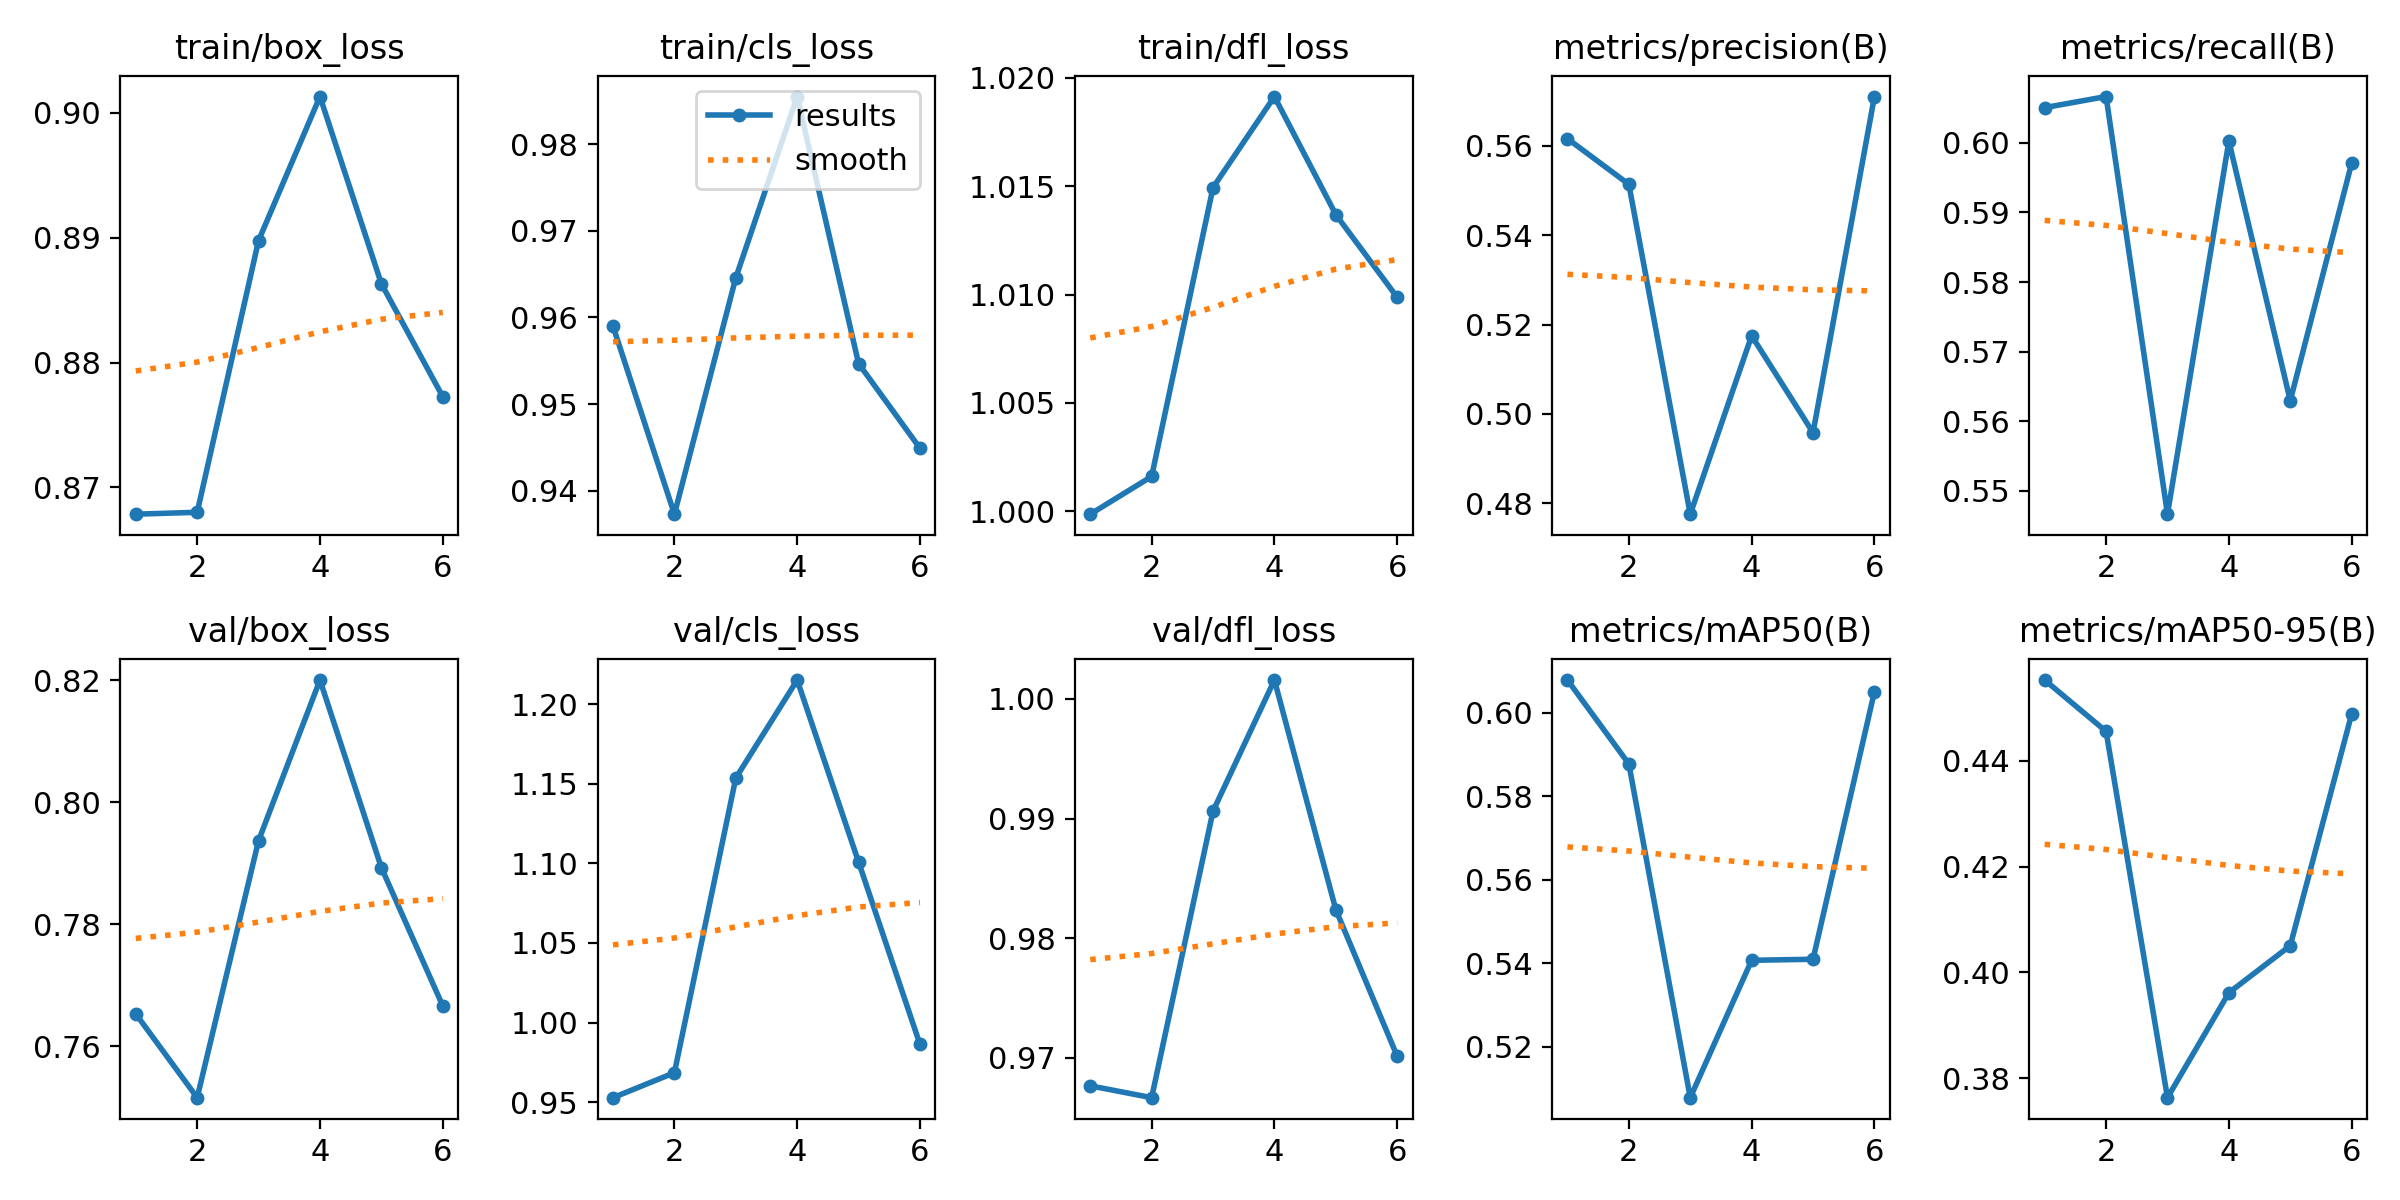

In [31]:
%cd {HOME}
Image(filename=f'{HOME}/{project}/{name}2/results.png', width=600)

/content


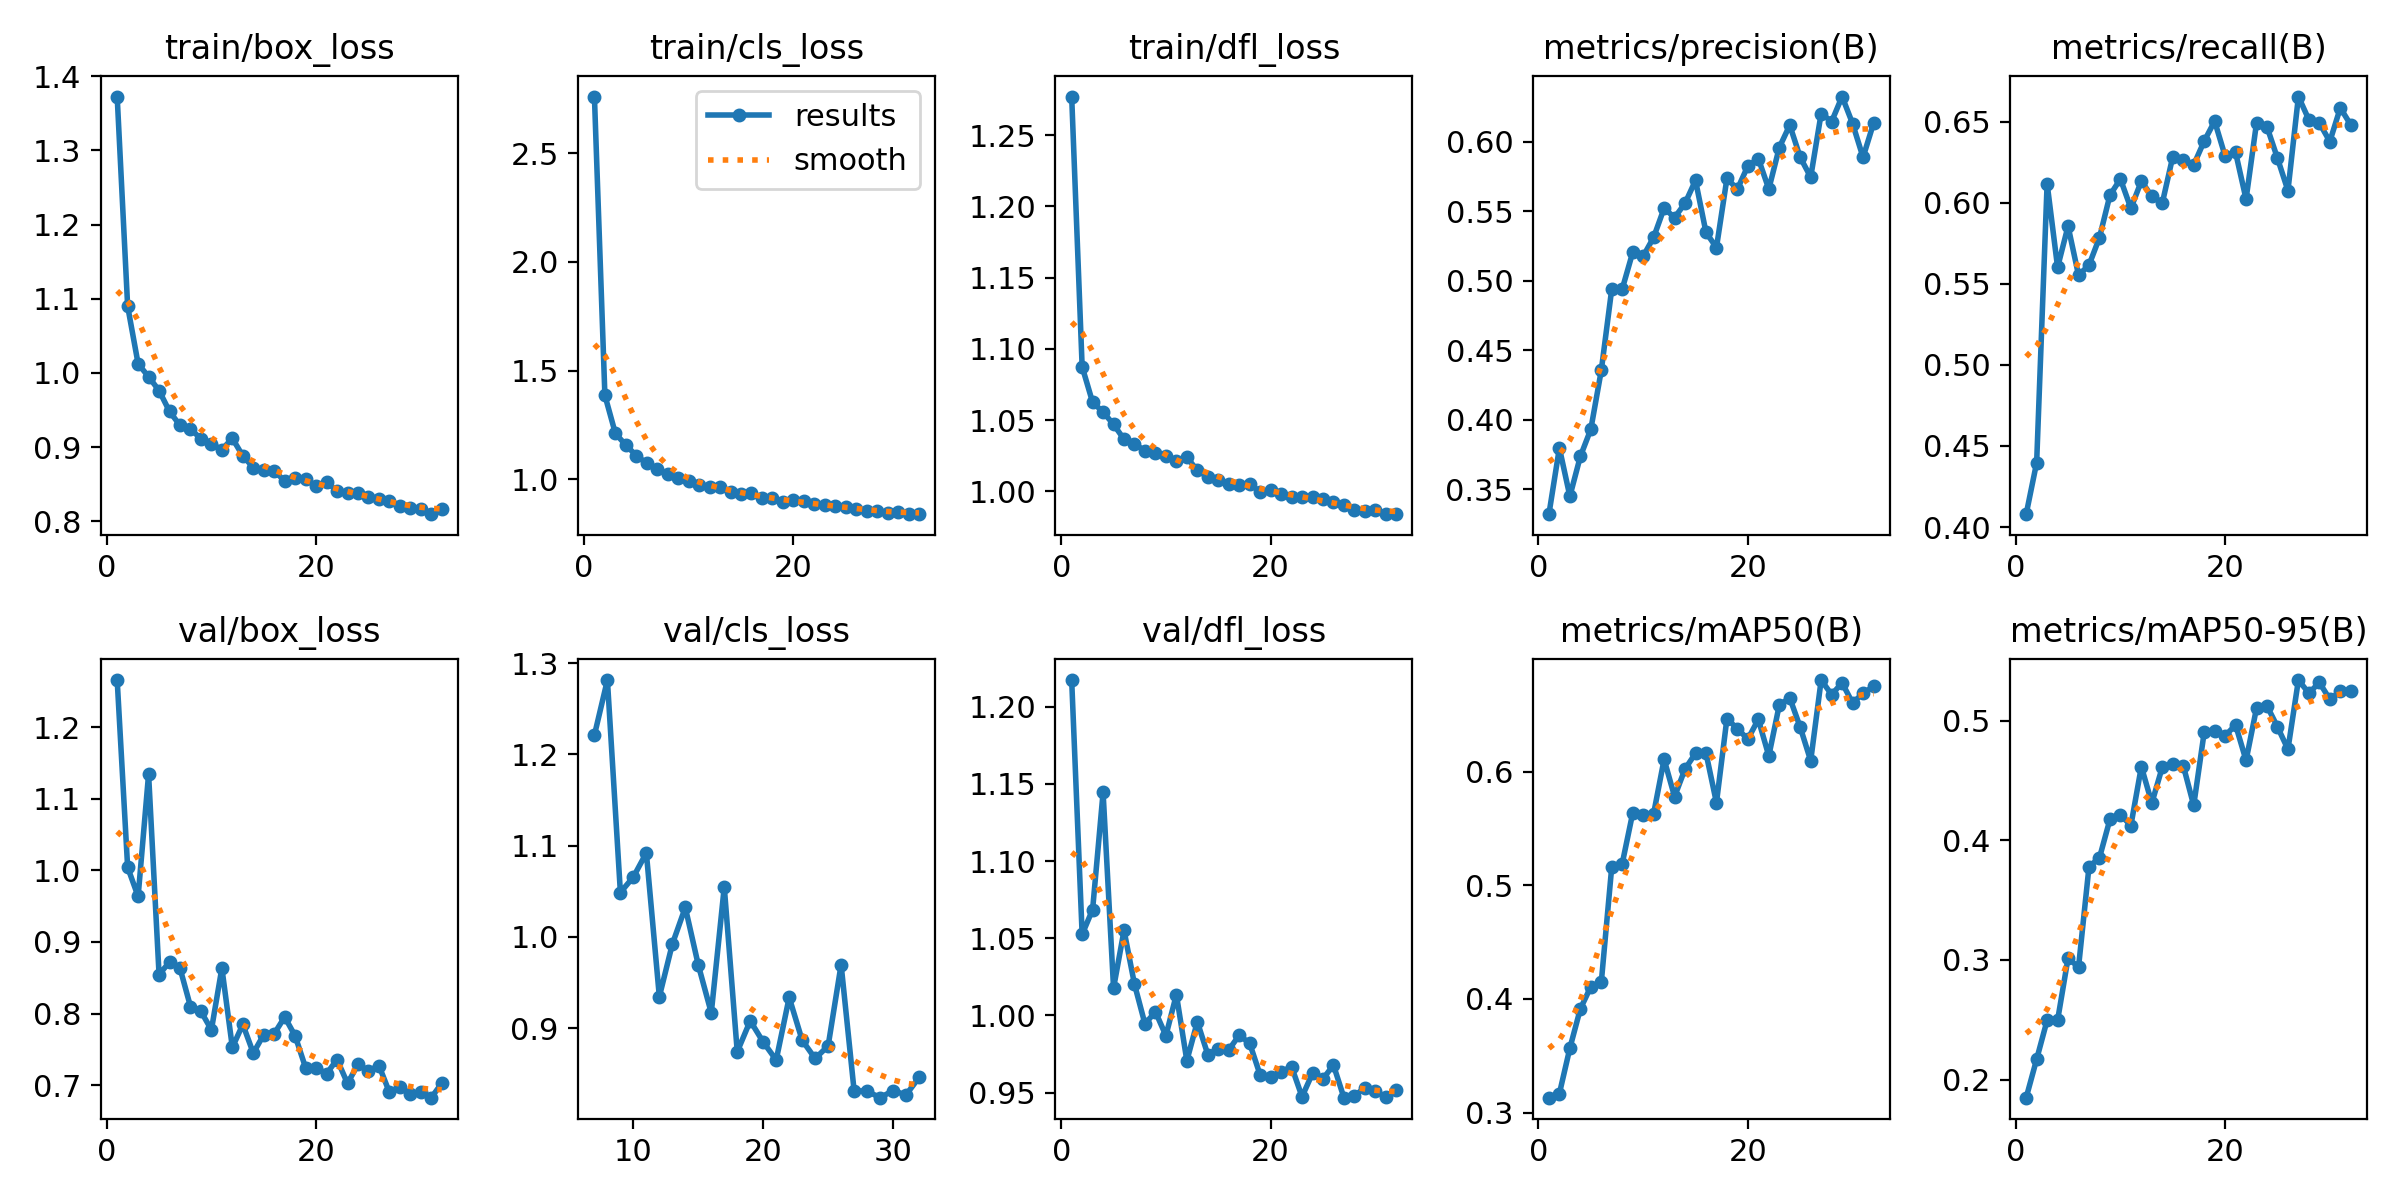

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

## Downloading Results (.zip file)

In [22]:
from google.colab import files

path_dir_to_zip = '/content/exploratory_phase/testing_data_splits_ratios' #@param {type: "string"}
output_filename = 'testing_data_splits_ratios_v2.zip' #@param {type: "string"}
path_zip_file = f'{HOME}/{output_filename}'
delete_zip_file_after_download = "No"  #@param ['Yes', 'No']

os.system( "zip -r {} {}".format( output_filename , path_dir_to_zip ) )

0

Download the requested zip file

In [23]:
files.download( output_filename )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Delete the created zip file (optional)

In [ ]:
if delete_zip_file_after_download == "Yes":
    os.system( "rm -r {}".format( path_zip_file ) )

# Draft Code (not important)

## Loading Training Datasets

Mound google drive which contains the required training dataset

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


Check internet speed (optional)

In [ ]:
!curl -s https://raw.githubusercontent.com/sivel/speedtest-cli/master/speedtest.py | python -

Retrieving speedtest.net configuration...
Testing from Google Cloud (34.126.168.143)...
Retrieving speedtest.net server list...
Selecting best server based on ping...
Hosted by PT. Jala Lintas Media (Semarang) [1171.81 km]: 30.175 ms
Testing download speed................................................................................
Download: 263.09 Mbit/s
Testing upload speed......................................................................................................
Upload: 184.19 Mbit/s


Print the current working directory in google collab

In [ ]:
!pwd

/content


Create a new directory for the dataset

In [ ]:
!mkdir data

In [ ]:
!cp -r ../gdrive/MyDrive/Colab\ Notebooks/datasets/hurricanedamagev7.v2i.yolov8.train.valid /content/data

Copy the whole directory with results to a connected google drive

In [ ]:
!scp -r /content/runs /content/gdrive/My Drive/ComputerVision/TrainingResults # adapt to own folder name